In [4]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [96]:
%load_ext autoreload
%autoreload 2

# --------------------------------------------------------------------------------

import os
import sys
from pathlib import Path
import numpy as np
np.warnings.filterwarnings('ignore')

# hex2cec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{os.environ['HOME']}/hex2vec")
sys.path.insert(0, f"{os.environ['HOME']}/amazon-routing-challenge")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
import urban_tools.hex_pipeline as hp
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd
import h3
import gcsfs

%matplotlib inline
import matplotlib.pyplot as plt
## Read in the DataFrame

p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/12.12.22-Revised-Embeddings/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
hh.print_history()
hh = hh.drop_zero_tags()
### Drop Tags that occur in <X% of a City
# percentage = 0.01
# import pandas as pd

# drop_cols = pd.Index([])
# for _hh in [hh]:
#     assert _hh.df["city"].unique().shape[0] == 1
#     h3_df = _hh.df.groupby('h3')[_hh.all_tags].first()
#     percent_occurance = (h3_df > 0).sum() / h3_df.shape[0]
#     drop_cols = drop_cols.union(percent_occurance[percent_occurance < percentage].index)
# hh.drop_cols(drop_cols)
# len(hh.all_tags)
### Append the embedding to the dataframe
# embedding_df = pd.read_parquet(
#     hh.my_folder / "embeddings.prq"
# )
embedding_df = pd.read_feather(
    "/gcsmount-research-data-staging/hex2vec-models/paper-final/embedding_dfs/subtags+cities+littlemodel.feather"
)
embedding_df = embedding_df.set_index("h3")
# embedding_df.columns = [f"e_{e}" for e in embedding_df.columns]
# embedding_df = embedding_df[embedding_df.columns.str.]
# embedding_columns = embedding_df.columns.copy()
# embedding_df = embedding_df.reset_index()

hh.df = hh.df.merge(embedding_df, on="h3", how="left")
hh.update_tags()
hh.df = hh.df.dropna(subset=hh.embeddings)
### Filter for only H3 with > X Data Points

# tagged_df = tagged_df.loc[tagged_df["h3_9"] > 20].copy()
hh = hh.filter_hex_occurance(20)
hh.df = hh.df[hh.df.city.str.contains('Boston')]
# hh.df.drop("h3_9", axis=1, inplace=True)
# print(tagged_df.shape)
hh.df = hh.df.reset_index(drop=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
read_cities(*(PosixPath('/gcsmount-research-data-staging/osmnx-cities/hexed-complete'),), **{'cities': ['Boston, USA', 'Austin, USA', 'Seattle, USA', 'Los Angeles, USA'], 'add_city_col': True})
create_super_tags(*(), **{})
Merge building_residential + building_house -> building_yes(*(), **{})
drop_zero_buildings(*(), **{})
drop_zero_building_area(*(), **{})
add_new_special_tag(*('building.area.average',), **{})
add_new_special_tag(*('parking.area.average',), **{})
append_route_df(*(), **{'grouped': False, 'tukey_fences': False})
open_route_df(*(), **{'grouped': False, 'tukey_fences': False})
drop_zero_tags(*(), **{})


### Create the TT Manager

In [97]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from scipy.stats import pearsonr

In [98]:
tt = TestTrainManager(
    hh.df,
    x_col=hh.embeddings.union(hh.special_tags).union(hh.super_tags),
    y_col=["planned_service_time_log"],
    scaler=RobustScaler,
    grouped=False,
    desired_quantiles=[0.1, 0.5, 0.90]
)

tt.split_test_train(train_size=0.8, random_seed=42)
tt.scale_test_train()
# split the tt.X_test into several chunks. Have to do this because of memory issues
tt.build_test_df(agg=False)

In [99]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.planned_service_time_log.values.ravel(), tt.X_test.values, tt.Y_test.loc.values
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [100]:
tt.X_train.shape, tt.X_test.shape

((14135, 74), (3347, 74))

In [101]:
X_train.shape, X_cal.shape, X_test.shape

((11308, 74), (2827, 74), (3347, 74))

## PCA

In [102]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import statistics as stat
from sklearn.linear_model import LinearRegression
import math
from sklearn import metrics
%matplotlib inline

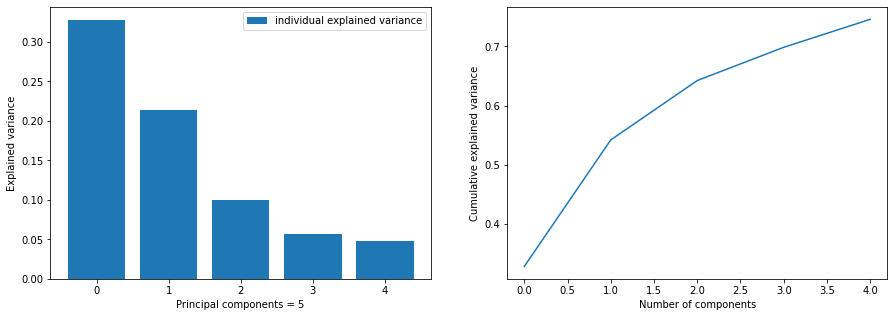

In [103]:
# n_components = X_train.shape[1]
n_components = 5
pca = PCA(n_components=n_components)
# pca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1)
X_pca = pca.fit_transform(X_train)
explained_variance=pca.explained_variance_ratio_

# explained_variance = np.var(X_pca, axis=0) / np.sum(np.var(X_pca, axis=0))

# create subplots for cumulative explained variance and individual explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot individual explained variance
ax1.bar(range(n_components), explained_variance, label='individual explained variance')
ax1.set_xlabel(f'Principal components = {n_components}')
ax1.set_ylabel('Explained variance')
ax1.legend()

# plot cumulative explained variance
ax2.plot(np.cumsum(explained_variance))
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative explained variance')

plt.show()


## Comparing Quantile/Conformal Predictions using 5-PCA components

### 1.  [Conformal Quantile Regression](https://arxiv.org/pdf/1905.03222.pdf)

In [104]:
import numpy as np
from quantile_forest import RandomForestQuantileRegressor

alpha = .5

# 1. Fit quantile regression model on training data
model = RandomForestQuantileRegressor(n_jobs=-1).fit(X_pca, y_train)

# 2. Make prediction on calibration data
y_cal_interval_pred = np.column_stack([
    model.predict(pca.fit_transform(X_cal), quantiles=[(alpha/2)]), 
    model.predict(pca.fit_transform(X_cal), quantiles=[(1-alpha/2)])])

# 3. Compute conformity scores on calibration data
y_cal_conformity_scores = np.maximum(
    y_cal_interval_pred[:,0] - y_cal, 
    y_cal - y_cal_interval_pred[:,1])

# 4. Get 1-alpha quantile from the distribution of conformity scores

#    Note: this is a single number
quantile_conformity_scores = np.quantile(
    y_cal_conformity_scores, 1-alpha)
    
# 5. Make prediction on test data
y_test_interval_pred = np.column_stack([
    model.predict(pca.fit_transform(X_test), quantiles=[(alpha/2)]), 
    model.predict(pca.fit_transform(X_test), quantiles=[(1-alpha/2)])])

# 6. Compute left (right) end of the interval by
#    subtracting (adding) the quantile to the predictions

y_test_interval_pred_cqr = np.column_stack([
    y_test_interval_pred[:,0] - quantile_conformity_scores,
    y_test_interval_pred[:,1] + quantile_conformity_scores])

In [124]:
from sklearn.ensemble import RandomForestRegressor
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score

alpha = 0.1
estimator = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
mapie = MapieRegressor(estimator=estimator, cv="prefit").fit(X_cal, y_cal)

y_test_pred, y_test_pis = mapie.predict(X_test, alpha=alpha)
y_test_interval_pred_mapie = y_test_pis.reshape(-1,2)

In [106]:
strategies = {'Mapie':{}, 'RandomForestQuantileRegressor':{}, 'CQR':{}}
intervals = [y_test_interval_pred_mapie, y_test_interval_pred, y_test_interval_pred_cqr]

for id, strategy in enumerate(strategies.keys()):
    if '% out of interval' not in strategies[strategy].keys():
        strategies[strategy]['% out of interval'] = 1-regression_coverage_score(y_test, intervals[id][:, 0], intervals[id][:, 1])
    if 'average interval width' not in strategies[strategy].keys():
        strategies[strategy]['average interval width'] = np.mean(intervals[id][:, 1] - intervals[id][:, 0])

pd.DataFrame(strategies).T

,% out of interval,average interval width
Mapie,0.100388,2.063218
RandomForestQuantileRegressor,0.498058,0.905908
CQR,0.498058,0.905908


#### Choosing quantiles is best for predictions

* get empirical points for every hexagon!

In [125]:
h3_index = hh.df.loc[tt._test_slice, 'h3']
test_df = tt.Y_test.loc.groupby(h3_index).agg({'mean', 'std'})
y_test_std = test_df['std']

In [126]:
empirical_pts_df = hh.df.loc[hh.df['h3'].isin(test_df.index)].groupby('h3').apply(lambda x: x['planned_service_time'].values)
empirical_pts_df = empirical_pts_df[test_df.index]
# y_test_std = np.array([tt.scaler.Y.transform(x.reshape(-1, 1)).std() for x in empirical_pts_df.values])

##### calculate standard deviation (`std`) using empirical points inside every hexagon!

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def get_test_predicted_intervals(X_train, y_train, X_cal, y_cal, X_test, alpha):
    
    estimator = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
    mapie = MapieRegressor(estimator=estimator, cv="prefit").fit(X_cal, y_cal)

    y_train_mean_pred, _ = mapie.predict(X_train, alpha=alpha)
    y_test_mean_pred, y_test_pis = mapie.predict(X_test, alpha=alpha)

    h3_index = hh.df.loc[tt._test_slice, 'h3']
    y_data = pd.DataFrame({'y_test':y_test, 'y_test_mean_pred':y_test_mean_pred, 'y_pred_lb':y_test_pis[:,0].ravel(), 'y_pred_ub':y_test_pis[:,1].ravel()}, index = h3_index)

    #  print coverage score and average interval width
    print(f'% out of interval: {(1-regression_coverage_score(y_test, y_test_pis[:, 0], y_test_pis[:, 1])):.2f}, average interval width: {round(np.mean(y_test_pis[:, 1] - y_test_pis[:, 0]), 2)}')


    # get the y_pred_df
    y_pred_df = y_data.groupby('h3')[['y_test_mean_pred', 'y_pred_lb', 'y_pred_ub']].first()
    y_pred_df['y_test'] = y_data.groupby('h3')[['y_test']].mean()

    # Only true for alpha = 0.1, for other values, the constant is different than 3.92!
    N = np.array([len(x) for x in empirical_pts_df.values])
    # if alpha == 0.1:
    #     y_test_std_pred =  ((y_pred_df['y_pred_ub'] - y_pred_df['y_pred_lb'])/5.15).ravel()
    # elif alpha == 0.05:
    #     y_test_std_pred = ((y_pred_df['y_pred_ub'] - y_pred_df['y_pred_lb'])/3.92).ravel()
    # elif alpha == 0.01:
    #     y_test_std_pred = ((y_pred_df['y_pred_ub'] - y_pred_df['y_pred_lb'])/3.29).ravel()
    # else:
    #     raise ValueError('Alpha not implemented')

    # y_pred_df['y_test_std'] = y_test_std_pred
    # print(y_test_std_pred[:5])

    # True upper and lower quantiles  
    scaled_true_lb = tt.Y_test.loc.groupby(h3_index).apply(lambda x: np.quantile(x, alpha/2))
    scaled_true_ub = tt.Y_test.loc.groupby(h3_index).apply(lambda x: np.quantile(x, 1-alpha/2))

    # print(f'Train MAPE: {mean_absolute_percentage_error(y_train, y_train_mean_pred):.3f}, Train RMSE: {mean_squared_error(y_train, y_train_mean_pred, squared=False):.3f}, Train R2: {r2_score(y_train, y_train_mean_pred):.3f}')
    print(f"Test Mean: MAPE= {mean_absolute_percentage_error(y_pred_df['y_test'], y_pred_df['y_test_mean_pred']):.3f}, Test RMSE= {mean_squared_error(y_pred_df['y_test'], y_pred_df['y_test_mean_pred'], squared=False):.3f}, Test R2= {r2_score(y_pred_df['y_test'], y_pred_df['y_test_mean_pred']):.3f}")
    # print('-'*50)
    # print('Std [\sqrt{N}(lower-upper)/3.92]-predicitions')
    # print(f'Train MAPE: {mean_absolute_percentage_error(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5):.3f}, Train RMSE: {mean_squared_error(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5, squared=False):.3f}, Train R2: {r2_score(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5):.3f}')
    # print(f'Test std: MAPE= {mean_absolute_percentage_error(y_test_std, y_test_std_pred):.3f}, Test RMSE: {mean_squared_error(y_test_std, y_test_std_pred, squared=False):.3f}, Test R2: {r2_score(y_test_std, y_test_std_pred):.3f}')
    print(f"Test lower Quantile: MAPE= {mean_absolute_percentage_error(scaled_true_lb, y_pred_df['y_pred_lb']):.3f}, Test RMSE: {mean_squared_error(scaled_true_lb, y_pred_df['y_pred_lb'], squared=False):.3f}, Test R2: {r2_score(scaled_true_lb, y_pred_df['y_pred_lb']):.3f}")
    # print(scaled_true_ub[:5])
    # print(y_pred_df['y_pred_ub'][:5])
    print(f"Test Upper Quantile: MAPE= {mean_absolute_percentage_error(scaled_true_ub, y_pred_df['y_pred_ub']):.3f}, Test RMSE: {mean_squared_error(scaled_true_ub, y_pred_df['y_pred_ub'], squared=False):.3f}, Test R2: {r2_score(scaled_true_ub, y_pred_df['y_pred_ub']):.3f}")
    print('-'*70)   

for alpha in [0.999, 0.5, 0.25, 0.15, 0.1, 0.05, 0.01]:
    print(f'CI: {int((1-alpha/2)*100)}%')
    get_test_predicted_intervals(X_train, y_train, X_cal, y_cal, X_test, alpha)

CI: 50%
% out of interval: 1.00, average interval width: 0.0
Test Mean: MAPE= 1.181, Test RMSE= 0.200, Test R2= 0.525
Test lower Quantile: MAPE= 6.503, Test RMSE: 0.218, Test R2: 0.543
Test Upper Quantile: MAPE= 20.286, Test RMSE: 0.219, Test R2: 0.542
----------------------------------------------------------------------
CI: 75%
% out of interval: 0.51, average interval width: 0.84
Test Mean: MAPE= 1.238, Test RMSE= 0.198, Test R2= 0.531
Test lower Quantile: MAPE= 14244095194132.010, Test RMSE: 0.200, Test R2: 0.495
Test Upper Quantile: MAPE= 2.664, Test RMSE: 0.249, Test R2: 0.437
----------------------------------------------------------------------
CI: 87%
% out of interval: 0.26, average interval width: 1.42
Test Mean: MAPE= 1.191, Test RMSE= 0.204, Test R2= 0.504
Test lower Quantile: MAPE= 0.528, Test RMSE: 0.227, Test R2: 0.271
Test Upper Quantile: MAPE= 0.738, Test RMSE: 0.281, Test R2: 0.358
----------------------------------------------------------------------
CI: 92%
% out o

## Plot for real service times vs hex-IDs

In [127]:
import plotly.express as px
import plotly.graph_objects as go

h3_index = hh.df.loc[tt._test_slice, 'h3']

# get the inverse transform of the y_pred
y_data = pd.DataFrame(data=np.exp(tt.scaler.Y.inverse_transform(tt.Y_test.loc.values.reshape(-1, 1)).reshape(-1)), index=h3_index, columns=['y_test'])
y_data.reset_index(inplace=True)
y_data['y_pred'] = np.exp(tt.scaler.Y.inverse_transform(y_test_pred.reshape(-1, 1)).reshape(-1))
y_data['y_pred_lb'] = np.exp(tt.scaler.Y.inverse_transform(y_test_pis[:, 0].reshape(-1, 1)).reshape(-1))
y_data['y_pred_ub'] = np.exp(tt.scaler.Y.inverse_transform(y_test_pis[:, 1].reshape(-1, 1)).reshape(-1))

# get the y_pred_df
y_pred_df = y_data.groupby('h3')[['y_pred', 'y_pred_lb', 'y_pred_ub']].first()
y_pred_df['y_true_lb'] = [np.quantile(x, alpha/2) for x in empirical_pts_df.values]
y_pred_df['y_true_ub'] = [np.quantile(x, 1-alpha/2) for x in empirical_pts_df.values]

y_pred_df['upper_error'] = np.abs(y_pred_df['y_pred_ub'] - y_pred_df['y_true_ub'])
y_pred_df['lower_error'] = np.abs(y_pred_df['y_pred_lb'] - y_pred_df['y_true_lb'])

In [128]:
# get the coverage dataframe
def calculate_coverage(x):
    return sum((x['y_test'] >= x['y_pred_lb'].values[0]) & (x['y_test'] <= x['y_pred_ub'].values[0])) / len(x['y_test'])


coverage_df = y_data.groupby('h3')[['y_test', 'y_pred_lb', 'y_pred_ub']].apply(calculate_coverage,)
print(coverage_df.mean())

0.9035624329910997


In [129]:
### Add a Plot of Coverage vs. actual std

# get the actual std
actual_std = hh.df.loc[tt._test_slice, 'planned_service_time'].groupby(h3_index).std()
y_pred_df['actual_std'] = actual_std
# add the true mean
y_pred_df['true_mean'] = hh.df.loc[tt._test_slice, 'planned_service_time'].groupby(h3_index).mean()
# add the true mean
y_pred_df['true_median'] = hh.df.loc[tt._test_slice, 'planned_service_time'].groupby(h3_index).median()
# add coverage score
y_pred_df['coverage'] = coverage_df

fig = px.scatter_matrix(
    y_pred_df
)
fig.update_layout(
    height=800,
    width=1200
)

fig.show(

)

In [130]:
### Add a Plot of Coverage vs. actual std

# get the actual std
actual_std = hh.df.loc[tt._test_slice, 'planned_service_time_log'].groupby(h3_index).std()


fig = px.scatter(
    x=actual_std,
    y=coverage_df,
)

fig.show()



In [131]:
# make a plotly figure with 2 y axes
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])


# sort the y_pred_df by the y_pred
y_pred_df.sort_index(inplace=True)
y_data.sort_values('h3', inplace=True)
coverage_df.sort_index(inplace=True)

fig.add_trace(
    go.Scatter(
        x=y_data['h3'],
        y=y_data['y_test'],
        mode="markers",
        name="Individual Deliveries"
    )
)

# add TRUE upper and lower bounds with fill
fig.add_trace(
    go.Scatter(
        x=y_pred_df.index,
        y=y_pred_df['y_true_lb'],
        mode="lines",
        line=dict(width=0),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=y_pred_df.index,
        y=y_pred_df['y_true_ub'],
        fill="tonexty",
        fillcolor="rgba(100,80,80,0.2)",
        line=dict(width=0),
        mode="lines",
        name="True Bounds"
    )
)

# add upper and lower bounds, with fill
fig.add_trace(
    go.Scatter(
        x=y_pred_df.index,
        y=y_pred_df['y_pred_lb'],
        mode="lines",
        line=dict(width=1),
        showlegend=True,
        name="Predicted Lower Bounds"
    )
)

fig.add_trace(
    go.Scatter(
        x=y_pred_df.index,
        y=y_pred_df['y_pred_ub'],
        fill="tonexty",
        fillcolor="rgba(0,100,80,0.2)",
        line=dict(width=1),
        mode="lines",
        showlegend=True,
        name="Predicted Upper Bound"
    )
)

# add the predicted mean
fig.add_trace(
    go.Scatter(
        x=y_pred_df.index,
        y=y_pred_df['y_pred'],
        mode="markers",
        marker=dict(color="rgba(255, 0, 0, 1)", size=10),
        name="Predicted Mean"
    )
)


# add the actual mean
fig.add_trace(
    go.Scatter(
        x=y_pred_df.index,
        y=y_pred_df['true_mean'],
        mode="markers",
        name="Actual Mean",
        # add a diamond marker
        marker=dict(color="green", size=10)
    )
)

# add the actual mean
fig.add_trace(
    go.Scatter(
        x=y_pred_df.index,
        y=y_pred_df['true_median'],
        mode="markers",
        name="Actual Median",
        # add a diamond marker
        marker=dict(color="yellow", size=10)
    )
)

# add title to axes
fig.update_xaxes(title_text="H3 Index")
fig.update_yaxes(title_text="Planned Service Time (seconds)")
fig.update_yaxes(title_text="Coverage", secondary_y=True)

# update the range on y2 axis
fig.update_yaxes(range=[0, 1], secondary_y=True)

# add a second y axis for the coverage
fig.add_trace(
    go.Scatter(
        x=coverage_df.index,
        y=coverage_df,
        mode="lines",
        yaxis="y2",
        name=f"Coverage (target is {int((1-alpha)*100)}%)"
    )
)

# open in a browser
fig.show(
    renderer="browser"
)



In [132]:
# hh.df.loc[tt._train_slice][['lat', 'lng', 'package_id','planned_service_time']].to_csv('./train_data_coordinates.csv')

In [133]:
hh.df.loc[tt._test_slice][['lat', 'lng', 'package_id','planned_service_time']].to_csv('./test_data_coordinates.csv')
y_pred_df.to_csv(f'./y_pred_df_{int((1-alpha/2)*100)}th_quantile.csv')

In [134]:
# combine the test and train data
df = pd.concat([hh.df.loc[tt._train_slice][['lat', 'lng', 'package_id','planned_service_time']], hh.df.loc[tt._test_slice][['lat', 'lng', 'package_id','planned_service_time']]])
# save the df
df.to_csv('./all_data_coordinates.csv')

#### Getting predictions for training

In [135]:
y_train_pred, y_train_pis = mapie.predict(tt.X_train.values, alpha=alpha)
h3_index_train = hh.df.loc[tt._train_slice, 'h3']
train_empirical_pts_df = hh.df.loc[hh.df['h3'].isin(h3_index_train)].groupby('h3').apply(lambda x: x['planned_service_time'].values)
# train_empirical_pts_df = train_empirical_pts_df[h3_index_train]
# y_test_std = np.array([tt.scaler.Y.transform(x.reshape(-1, 1)).std() for x in empirical_pts_df.values])
# get the inverse transform of the y_pred
y_train_data = pd.DataFrame(data=np.exp(tt.scaler.Y.inverse_transform(tt.Y_train.values.reshape(-1, 1)).reshape(-1)), index=h3_index_train, columns=['y_test'])
y_train_data.reset_index(inplace=True)
y_train_data['y_pred'] = np.exp(tt.scaler.Y.inverse_transform(y_train_pred.reshape(-1, 1)).reshape(-1))
y_train_data['y_pred_lb'] = np.exp(tt.scaler.Y.inverse_transform(y_train_pis[:, 0].reshape(-1, 1)).reshape(-1))
y_train_data['y_pred_ub'] = np.exp(tt.scaler.Y.inverse_transform(y_train_pis[:, 1].reshape(-1, 1)).reshape(-1))

# get the y_pred_df
y_df = y_train_data.groupby('h3')[['y_pred', 'y_pred_lb', 'y_pred_ub']].first()
y_df['y_true_lb'] = [np.quantile(x, alpha/2) for x in train_empirical_pts_df.values]
y_df['y_true_ub'] = [np.quantile(x, 1-alpha/2) for x in train_empirical_pts_df.values]

y_df['upper_error'] = np.abs(y_df['y_pred_ub'] - y_df['y_true_ub'])
y_df['lower_error'] = np.abs(y_df['y_pred_lb'] - y_df['y_true_lb'])


# get the actual std
y_df['actual_std'] = hh.df.loc[tt._train_slice, 'planned_service_time'].groupby(h3_index_train).std()
# add the true mean
y_df['true_mean'] = hh.df.loc[tt._train_slice, 'planned_service_time'].groupby(h3_index_train).mean()
# add the true mean
y_df['true_median'] = hh.df.loc[tt._train_slice, 'planned_service_time'].groupby(h3_index_train).median()
# add coverage score
y_df['coverage'] = y_train_data.groupby('h3')[['y_test', 'y_pred_lb', 'y_pred_ub']].apply(calculate_coverage,)

In [139]:
y_df

,y_pred,y_pred_lb,y_pred_ub,y_true_lb,y_true_ub,upper_error,lower_error,actual_std,true_mean,true_median,coverage
h3,,,,,,,,,,,
892a3064103ffff,141.372110,41.815709,477.956112,40.15,517.090,39.133888,1.665709,164.300073,194.939216,147.5,0.862745
892a306410fffff,100.170179,29.628807,338.659083,32.75,490.275,151.615917,3.121193,147.669934,146.246429,94.0,0.857143
892a3064113ffff,147.496725,43.627276,498.662439,53.00,521.000,22.337561,9.372724,171.393519,198.995082,155.1,0.901639
892a306411bffff,158.250880,46.808191,535.020488,51.35,664.550,129.529512,4.541809,223.703639,232.762963,171.0,0.851852
892a306412bffff,269.093111,79.593628,909.760044,81.10,615.060,294.700044,1.506372,161.637538,309.210256,284.0,0.948718
...,...,...,...,...,...,...,...,...,...,...,...
892a339a4b3ffff,137.579584,40.693937,465.134198,54.30,290.290,174.844198,13.606063,104.603498,157.791304,123.0,0.956522
892a339a583ffff,89.758090,26.549071,303.457504,33.95,277.660,25.797504,7.400929,121.149096,124.060000,76.5,0.950000
892a339a58bffff,53.523507,15.831435,180.954273,22.00,200.175,19.220727,6.168565,61.505878,72.376923,54.0,0.923077


### Merge train test predictions to display them together

In [136]:
# combine the test and train data
pred_df = pd.concat([y_df, y_pred_df])
# save the df
pred_df.to_csv(f'./all_predictions_{int((1-alpha/2)*100)}th_quantile.csv')